[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/boostcourse-ds-511/blob/master/pima-regression-baseline-01.ipynb)

## 데이터셋 출처
* [Pima Indians Diabetes Database | Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html


### 데이터 구성

* Pregnancies : 임신 횟수
* Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도 
* BloodPressure : 이완기 혈압 (mm Hg)
* SkinThickness : 삼두근 피부 주름 두께 (mm), 체지방을 추정하는데 사용되는 값
* Insulin : 2시간 혈청 인슐린 (mu U / ml)
* BMI : 체질량 지수 (체중kg / 키(m)^2)
* DiabetesPedigreeFunction : 당뇨병 혈통 기능
* Age : 나이
* Outcome : 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0입니다.


## 필요한 라이브러리 로드

In [316]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy
# 시각화를 위한 seaborn, matplotlib.pyplot 을 로드합니다. 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 데이터셋 로드

In [317]:
df = pd.read_csv("../data/diabetes.csv")
df.shape

(768, 9)

In [318]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 학습, 예측 데이터셋 나누기

In [319]:
# label 값을 기준으로 나눕니다.
# 나누기 전에 label 값을 시각화 합니다.
(df["Insulin"]>0).value_counts()

True     394
False    374
Name: Insulin, dtype: int64

In [320]:
# train 세트를 만듭니다.
train=df[df["Insulin"]>0].copy()
train.shape


(394, 9)

In [321]:
# test 세트를 만듭니다.

test = df[df["Insulin"] == 0].copy()
test.shape

(374, 9)

In [322]:
test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


## EDA

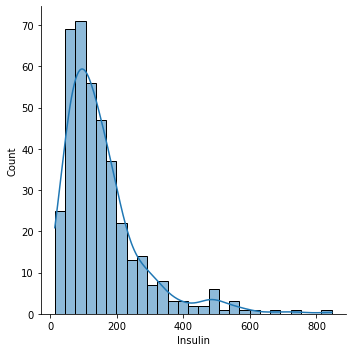

In [323]:
# sns.distplot(train["Insulin"])
sns.displot(data=train, x="Insulin", kde=True)

<AxesSubplot:xlabel='Insulin'>

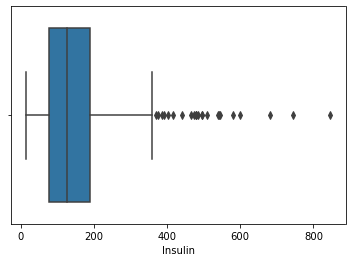

In [324]:
sns.boxplot(data=train, x="Insulin")

In [325]:
desc = train["Insulin"].describe()
desc

count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

In [326]:
# IQR =  3IQR - 1IQR
# OUT > 3IQR + (IQR * 1.5)
IQR = desc.loc["75%"] - desc.loc["25%"]
print(IQR)
OUT = desc.loc["75%"] + (IQR * 1.5)
print(OUT)

113.75
360.625


In [327]:
train[train["Insulin"]>OUT].shape

(24, 9)

In [328]:
print(train.shape)
train=train[train["Insulin"]<OUT]
train

(394, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
14,5,166,72,19,175,25.8,0.587,51,1
16,0,118,84,47,230,45.8,0.551,31,1
...,...,...,...,...,...,...,...,...,...
751,1,121,78,39,74,39.0,0.261,28,0
755,1,128,88,39,110,36.5,1.057,37,1
760,2,88,58,26,16,28.4,0.766,22,0
763,10,101,76,48,180,32.9,0.171,63,0



## 학습, 예측에 사용할 컬럼

In [329]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.

feature_names=test.columns.tolist()
feature_names.remove("Insulin")
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

## 정답값이자 예측해야 될 값

In [330]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.

label_name = "Insulin"
label_name

'Insulin'

## 학습, 예측 데이터셋 만들기

In [331]:
# 학습 세트 만들기 예) 시험의 기출문제
X_train=train[feature_names]
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1
6,3,78,50,32,31.0,0.248,26,1
14,5,166,72,19,25.8,0.587,51,1
16,0,118,84,47,45.8,0.551,31,1
...,...,...,...,...,...,...,...,...
751,1,121,78,39,39.0,0.261,28,0
755,1,128,88,39,36.5,1.057,37,1
760,2,88,58,26,28.4,0.766,22,0
763,10,101,76,48,32.9,0.171,63,0


In [332]:
# 정답 값을 만들어 줍니다. 예) 기출문제의 정답
y_train=train[label_name]
y_train

3       94
4      168
6       88
14     175
16     230
      ... 
751     74
755    110
760     16
763    180
765    112
Name: Insulin, Length: 370, dtype: int64

In [333]:
# 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제

X_test=test[feature_names]
X_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
5,5,116,74,0,25.6,0.201,30,0
7,10,115,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...
761,9,170,74,31,44.0,0.403,43,1
762,9,89,62,0,22.5,0.142,33,0
764,2,122,70,27,36.8,0.340,27,0
766,1,126,60,0,30.1,0.349,47,1


In [334]:
# 예측의 정답값 예) 실전 시험 문제의 정답
y_test=test[label_name]
y_test

0      0
1      0
2      0
5      0
7      0
      ..
761    0
762    0
764    0
766    0
767    0
Name: Insulin, Length: 374, dtype: int64

## 머신러닝 알고리즘 가져오기

In [335]:
from sklearn.tree import DecisionTreeRegressor
model= DecisionTreeRegressor(random_state=42)
model

DecisionTreeRegressor(random_state=42)

## 학습(훈련)
* 시험을 볼 때 기출문제(X_train)와 정답(y_train)을 보고 공부하는 과정과 유사합니다.

In [336]:
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

## cross validation 으로 학습 세트의 오차 측정하기

In [337]:
from sklearn.model_selection import cross_val_predict
y_predict=cross_val_predict(model, X_train, y_train, cv=5, verbose=3, n_jobs=-1)
y_predict[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


array([ 25., 182.,  55., 144., 220.])

In [338]:
# 정답을 정확하게 맞춘 갯수
(y_predict==y_train).sum()

7

In [339]:
len(y_train)

370

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


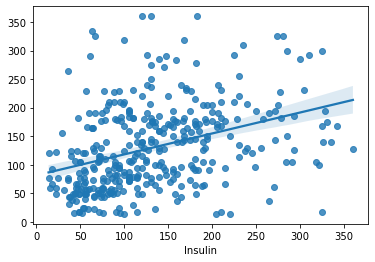

In [340]:
# regplot 으로 결과 값을 비교합니다.

sns.regplot(y_train, y_predict)
plt.show()

In [341]:
# r2_score 를 구합니다.

from sklearn.metrics import r2_score

r2_score(y_train, y_predict)

-0.28551906710833275

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


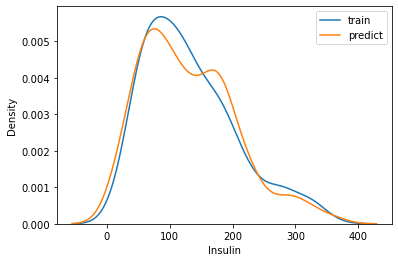

In [342]:
# distplot으로 정답값과 예측값의 분포를 그립니다.
sns.distplot(y_train,hist=False, label="train")
sns.distplot(y_predict,hist=False, label="predict")
plt.legend()
plt.show()


## 오차 구하기

In [343]:
# MAE
# 86
# 77.55
# 62.05
error=abs(y_train-y_predict)
error.mean()

62.056756756756755

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


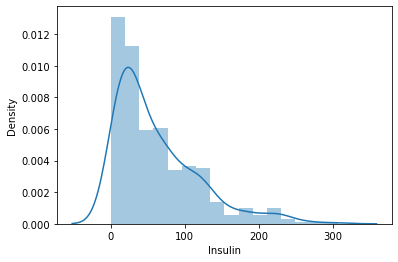

In [344]:
sns.distplot(error)
plt.show()

In [345]:
error.describe()

count    370.000000
mean      62.056757
std       56.854443
min        0.000000
25%       19.250000
50%       42.500000
75%       89.750000
max      307.000000
Name: Insulin, dtype: float64

In [346]:
# RMSE
# 126.895
# 114.077 (Insulin<600)
# 84        (Insulin<OUT)

np.sqrt(((y_train - y_predict) ** 2).mean())

84.11142866717003

## 트리 알고리즘 분석하기
* 의사결정나무를 시각화 합니다.
* 피처의 중요도를 구합니다.

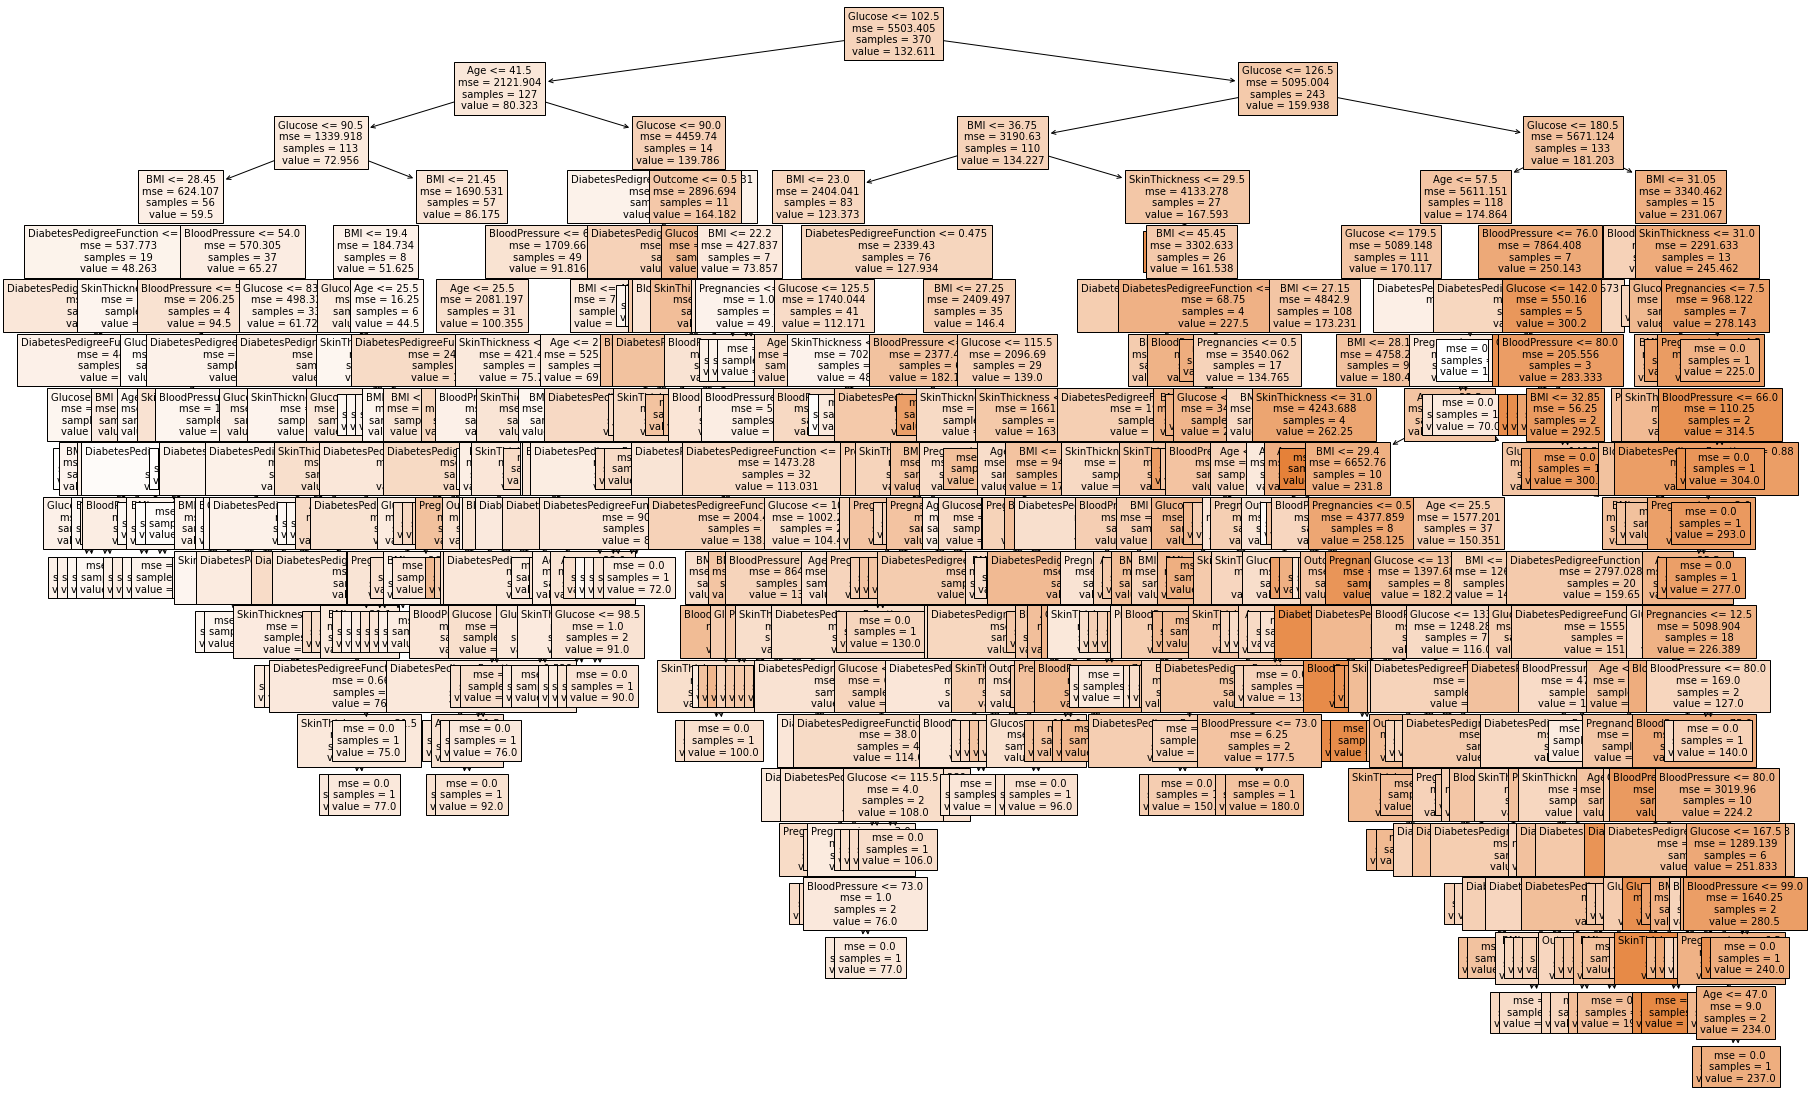

In [347]:
# plot_tree로 시각화 하기
from sklearn.tree import plot_tree

plt.figure(figsize=(30,20))
tree=plot_tree(model,
          feature_names=feature_names,
          filled=True,
          fontsize=10)


In [348]:
# 피처의 중요도를 추출하기
model.feature_importances_

array([0.04858345, 0.44656558, 0.07097731, 0.05588694, 0.16087336,
       0.09607089, 0.11025783, 0.01078464])

<AxesSubplot:>

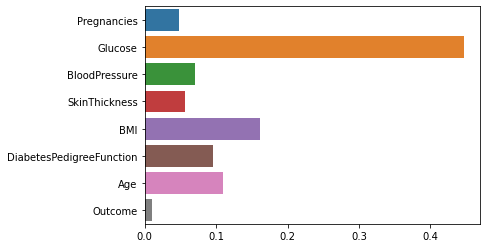

In [349]:
# 피처의 중요도 시각화 하기
sns.barplot(x=model.feature_importances_, y=feature_names)

## 예측
* 실전 시험문제(X_test)라고 보면 됩니다. 우리가 정답을 직접 예측합니다.
* Insulin 이 0인 값을 예측 했기 때문에 정답을 알 수 없습니다.
* 따라서 점수는 train set로 측정한 값을 참고합니다.

In [350]:
x_test_predict=model.predict(X_test)
x_test_predict[:5]

array([168.,  37., 130., 215., 165.])

In [351]:
train.groupby("Outcome")["Insulin"].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,254.0,115.917323,69.844697,15.0,64.25,100.0,151.00,342.0
1,116.0,169.163793,70.789454,14.0,124.25,160.0,207.75,360.0


In [352]:
test["Insulin"]= x_test_predict
test.groupby("Outcome")["Insulin"].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,236.0,124.906780,80.878263,18.0,64.00,97.5,155.0,335.0
1,138.0,163.724638,83.718835,14.0,96.75,145.0,215.0,328.0


<AxesSubplot:xlabel='Outcome', ylabel='Insulin'>

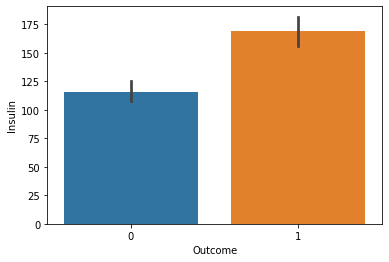

In [353]:
# Insulin 평균값을 출력
sns.barplot(data=train, x="Outcome", y="Insulin")

<AxesSubplot:xlabel='Outcome', ylabel='Insulin'>

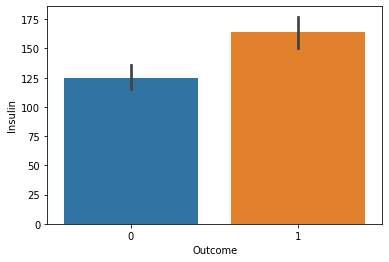

In [354]:
# 예측값
sns.barplot(data=test, x="Outcome", y="Insulin")

In [359]:
test["Insulin"]

0      168.0
1       37.0
2      130.0
5      215.0
7      165.0
       ...  
761    328.0
762     94.0
764    325.0
766     22.0
767     88.0
Name: Insulin, Length: 374, dtype: float64